# Import the required libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the datasets

In [2]:
# Specify the file directory where the dataset will be loaded from.
file = r"C:\Users\Mohammad\OneDrive\Desktop\Project\suena_application_test"

# Load each file into its respective dataset based on the filename.
auction_data = pd.read_csv(file + r'\auction_data.csv', sep=';', skiprows=0, index_col=0, parse_dates=True, dayfirst=True)
forecast_inputs = pd.read_csv(file + r'\forecast_inputs.csv', sep=';', skiprows=0, index_col=0, parse_dates=True, dayfirst=True)
system_prices = pd.read_csv(file + r'\system_prices.csv', sep=';', skiprows=0, index_col=0, parse_dates=True, dayfirst=True)

# Data Preprocessing

In [3]:
# Convert the string values to floating-point numbers.
def convert_to_float(value):
    try:
        if isinstance(value, str) and '-' in value: # Determine whether the value is negative.
            return -1.0 * float(value.replace('-', ''))
        
        else:
            return float(value)
        
    except:
        return np.nan

In [4]:
def Preprocessing(df):
    df.index = (pd.to_datetime(df.index, format='[%d/%m/%Y %H:%M]')) # Convert the index to a time series.
    df = df.drop('NaT')  # Remove any unnecessary rows from the dataset.
    df = df.applymap(convert_to_float) # Convert the strings to floating-point numbers.
    df = df[~df.index.duplicated()] # Remove any duplicate columns in the dataset.
    df = df.resample('H').asfreq() # Add any missing timesteps to the dataset.
    df = df.interpolate(method='linear') # Fill in any missing timesteps in the dataset using linear interpolation.
    return df

In [5]:
auction_data = Preprocessing(auction_data) # Preprocess the auctions data 
forecast_inputs = Preprocessing(forecast_inputs) # Preprocess the forecast inputs data
system_prices = Preprocessing(system_prices) # Preprocess the system prices data

# Prepare training and testing sets

In [6]:
# Split the dataset into separate training and testing sets. The training set includes data from the beginning of the dataset until the end of February 2022, while the testing set includes the remaining data.

auction_data_train = auction_data.loc[auction_data.index < '2022-03-01']
auction_data_test = auction_data.loc[auction_data.index >= '2022-03-01']

forecast_inputs_train = forecast_inputs.loc[forecast_inputs.index < '2022-03-01']
forecast_inputs_test = forecast_inputs.loc[forecast_inputs.index >= '2022-03-01']

system_prices_train = system_prices.loc[system_prices.index < '2022-03-01']
system_prices_test = system_prices.loc[system_prices.index >= '2022-03-01']

# Forecasting model

In [7]:
def Forecast(y_train, X_train, X_test, model_name=None):
    """
    This code defines a function to perform time series forecasting using different models, including 
    ARIMA, XGBoost, Linear Regression, Lasso, and MLPRegressor.
    
    Parameters:
        y_train : The true label of the training data.
        X_train : The training data.
        X_test : The testing data.
        model_name : The model name.
    
   Returns:
        predicted values.
        """
    
    if model_name == "ARIMA":
        # ARIMA "Autoregressive integrated moving average" model.
        model = ARIMA(y_train, exog=X_train, order=(1, 1, 1))
        # Fit ARIMA on the training data.
        model = model.fit()
        
        # Use the trained ARIMA model to generate predictions for the testing data.
        prediction = model.forecast(steps=len(X_test), exog=X_test) 
        
        return prediction

    elif model_name == "XGBBoost":
        # XGBoost Regression model.
        model = xgb.XGBRegressor()

    elif model_name == "LinearRegression":
        # Linear Regression model.
        model = LinearRegression()        
    
    elif model_name == "Lasso":
        # Lasso "Least Absolute Shrinkage and Selection Operator" model.
        model = Lasso()
        
    elif model_name == "MLPRegressor":
        # MLPRegressor "multi-layer perceptron Regression" model.
        model = MLPRegressor(hidden_layer_sizes=(100,100), random_state=1, max_iter=500)

    else:
        return 0
    
    # Fit model on the training data.
    model.fit(X_train, y_train)
    
    # Make predictions for the testing data.
    prediction = model.predict(X_test)
    
    return prediction

In [8]:
# Create a list of target data to be used for forecasting.
forecasts = ["price_second_auction", "traded_volume_first_auction", "traded_volume_second_auction"]

# Create a dataframe to store the forecast values.
forecast_auctions = auction_data_test[ 'price_forecast_first_auction'].to_frame('forecast_price_first_auction')

# A list of the models used to generate the forecasts
model_names = ['ARIMA', 'XGBBoost', 'LinearRegression', 'Lasso', 'MLPRegressor']

for forecast in forecasts:

    print("forecast : ", forecast)
    
    # Create the training set.
    X_train = forecast_inputs_train
    y_train = auction_data_train[forecast]

    # Create the testing set.
    X_test = forecast_inputs_test
    y_test = auction_data_test[forecast]
    
    predictions = 0
    
    # Generate a forecast using all models.
    for model_name in model_names: 
        
        # Save the forecasts for each auction prediction.
        globals()[model_name + "forecast_" + forecast] = Forecast(y_train=y_train, X_train=X_train, X_test=X_test, model_name=model_name)
        predictions += globals()[model_name + "forecast_" + forecast]
        
    # Compute the average of the forecasts generated by all models.
    predictions = predictions / len(model_names)
    
    # Store the forecasts in a dataset that contains the prediction for each auction.
    forecast_auctions["forecast_" + forecast] = predictions

forecast :  price_second_auction


C:\Users\Mohammad\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mohammad\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e+07, tolerance: 1.062e+04
  model = cd_fast.enet_coordinate_descent(


forecast :  traded_volume_first_auction


C:\Users\Mohammad\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mohammad\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e+09, tolerance: 1.373e+06
  model = cd_fast.enet_coordinate_descent(


forecast :  traded_volume_second_auction


C:\Users\Mohammad\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Mohammad\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+10, tolerance: 7.814e+06
  model = cd_fast.enet_coordinate_descent(


# Create a DataFrame to carry on the trading algorithm.

In [9]:
df = forecast_auctions.copy()

# Trading strategy

To ensure a zero net position in a non-physical trading scenario, the safe trading volume is computed at each timestep. This is done by selecting the minimum trading volume between the two auctions.

In [10]:
df['trading_volume_for_both_auctions'] = df[['forecast_traded_volume_first_auction', 'forecast_traded_volume_second_auction']].min(axis=1)

The prices of the two auctions should be compared to make an initial trading decision. For the first auction, if the forecasted price, including taxes and fees, is lower than that of the second auction, it is advisable to buy electricity. Conversely, if the price in the first auction is higher than in the second, along with taxes and fees, it is recommended to sell electricity. If neither of these conditions is met, holding (i.e., stop trading) for the first auction is best. The decision is then reversed for the second auction.

In [11]:
taxes = 10 * 2 # GBP/MWh

df['first_auction_sell_buy'] = np.where(df['forecast_price_first_auction'] + taxes < df['forecast_price_second_auction'], 'Buy electricity', 
                         np.where(df['forecast_price_first_auction'] > df['forecast_price_second_auction'] + taxes, 'Sell electricity', 'Hold'))

df['second_auction_sell_buy'] = df['first_auction_sell_buy'].replace({'Buy electricity': 'Sell electricity', 'Sell electricity': 'Buy electricity',  'Hold' : 'Hold'})

Calculate the expected profit per MWH by determining the difference between the expected prices for the first and second auctions.

In [12]:
df['diff'] = np.where(df['first_auction_sell_buy'] == 'Sell electricity', 
                         df['forecast_price_first_auction'] - df['forecast_price_second_auction'],
                 np.where(df['first_auction_sell_buy'] == 'Buy electricity',
                         df['forecast_price_second_auction'] - df['forecast_price_first_auction'], 0))

df = df.fillna(0)

# Trading bids

First auction bids dataset, which contains information on the trading price, volume, and action (sell, buy, or hold).

In [13]:
# First auction bids
first_auction_bids = df[['forecast_price_first_auction', 'trading_volume_for_both_auctions', 'first_auction_sell_buy']]
first_auction_bids = first_auction_bids.rename(columns={"forecast_price_first_auction": "trading_price",
                                                      "trading_volume_for_both_auctions": "trading_volume",
                                                      "first_auction_sell_buy": "action"})

Set the risk percentage as a percentage of the expected profit.

In [14]:
risk_percentage_first_auction = 0.05 # the risk is 0.05% of expected profit.

Adjust the first auction trading price based on the risk percentage.

In [15]:
first_auction_bids['trading_price'] = np.where(first_auction_bids['action'] == 'Sell electricity', 
                                              first_auction_bids['trading_price'] - (df['diff'] * risk_percentage_first_auction),
                                     np.where(first_auction_bids['action'] == 'Buy electricity', 
                                              first_auction_bids['trading_price'] + (df['diff'] * risk_percentage_first_auction), 0))

first_auction_bids.loc[first_auction_bids['action'] == "Hold", ['trading_price', 'trading_volume']] = 0

Create a dataset that includes the actual prices, volumes, and profits/losses for the submitted auctions, which will be used to determine whether bids were accepted.

In [16]:
actual = auction_data_test.loc[df.index,['price_first_auction', 'price_second_auction', 
                                    'traded_volume_first_auction', 'traded_volume_second_auction']]

actual["trading_volume_for_both_auctions"] = actual[['traded_volume_first_auction', 'traded_volume_second_auction']].min(axis=1)

actual['diff'] = np.where(df['first_auction_sell_buy'] == 'Sell electricity', 
                         actual['price_first_auction'] - actual['price_second_auction'],
                 np.where(df['first_auction_sell_buy'] == 'Buy electricity',
                         actual['price_second_auction'] - actual['price_first_auction'], 0))
actual = actual.fillna(0)

To determine whether the first auction bid was accepted, compare the bid price to the actual price (i.e., clearing price). If the bid was for selling and the bid price was below or equal to the actual price, the bid is accepted. Similarly, if the bid was for buying and the bid price was higher than the actual price, the bid is accepted.

In [17]:
accepted = pd.Series(False, index=df.index)

accepted.loc[first_auction_bids['action'] == "Hold"] = False

accepted.loc[first_auction_bids['action'] == "Sell electricity"] = (
    actual.loc[first_auction_bids['action'] == "Sell electricity" , 'price_first_auction'] >= 
          first_auction_bids.loc[first_auction_bids['action'] == "Sell electricity" , 'trading_price']) 

accepted.loc[first_auction_bids['action'] == "Buy electricity"] = (
    actual.loc[first_auction_bids['action'] == "Buy electricity"  , 'price_first_auction'] <= 
          first_auction_bids.loc[first_auction_bids['action'] == "Buy electricity", 'trading_price'])

accepted = accepted.replace({True: 'accepted', False: 'unaccepted'})

Create a new dataset that includes only the accepted bids, where the price is set to the clearing price and the trading volume is set to the lower of the actual volume and the volume from the auction.

In [18]:
accepted_bids_first = first_auction_bids.copy()

accepted_bids_first.loc[accepted == "unaccepted",'action'] = "Hold"
accepted_bids_first.loc[accepted_bids_first['action'] == "Hold", [ 'trading_price', 'trading_volume']] = 0

accepted_bids_first.loc[accepted_bids_first['action'] != "Hold", 'trading_volume'] = np.minimum(accepted_bids_first.loc[accepted_bids_first['action'] != "Hold", 'trading_volume'],
                                                                                            actual.loc[accepted_bids_first['action'] != "Hold", 'traded_volume_first_auction'])

accepted_bids_first.loc[accepted_bids_first['action'] == "Buy electricity", 'trading_price'] = actual.loc[accepted_bids_first['action'] == "Buy electricity", 'price_first_auction']
accepted_bids_first.loc[accepted_bids_first['action'] == "Sell electricity", 'trading_price'] = actual.loc[accepted_bids_first['action'] == "Sell electricity", 'price_first_auction']

Since the auctions are sequential, the results of the first auction are available before the second auction begins. Therefore, all accepted bids at each timestep are retracted in the second auction. The second auction bids are created as follows: first, the action (buy or sell) is the opposite of the bids accepted in the first auction. Second, the trading volume for the second auction is the same as for the accepted bids in the first auction. Finally, the bid price for selling is set lower than the expected price, and the bid price for buying is set higher than the expected price since the mechanism is pay-as-cleared. This process ensures that the trading volume of each timestep at the end is zero since the trading method is non-physical.

In [19]:
second_auction_bids = accepted_bids_first.copy()

second_auction_bids['action'] = second_auction_bids['action'].replace({'Buy electricity': 'Sell electricity', 'Sell electricity': 'Buy electricity',  'Hold' : 'Hold'})

Since the mechanism is pay-as-cleared, and the bids would not have changed the auction prices, set the buying price higher than expected and the selling price lower than expected to ensure that all the accepted bids from the first auction are sold in the second auction, while keeping the volume the same as in the first auction

In [20]:
second_auction_bids.loc[second_auction_bids['action'] == "Sell electricity", "trading_price"] = df.loc[second_auction_bids['action'] == "Sell electricity", "forecast_price_second_auction"] * 0.1
second_auction_bids.loc[second_auction_bids['action'] == "Buy electricity", "trading_price"] = df.loc[second_auction_bids['action'] == "Buy electricity", "forecast_price_second_auction"] * 10

To determine whether the second auction bid was accepted, compare the bid price to the actual price (i.e., clearing price). If the bid was for selling and the bid price was below or equal to the actual price, the bid is accepted. Similarly, if the bid was for buying and the bid price was higher than the actual price, the bid is accepted.

In [21]:
accepted = pd.Series(False, index=df.index)

accepted.loc[second_auction_bids['action'] == "Hold"] = False

accepted.loc[second_auction_bids['action'] == "Sell electricity"] = (
    actual.loc[second_auction_bids['action'] == "Sell electricity" , 'price_second_auction'] >= 
          second_auction_bids.loc[second_auction_bids['action'] == "Sell electricity" , 'trading_price']) 

accepted.loc[second_auction_bids['action'] == "Buy electricity"] = (
    actual.loc[second_auction_bids['action'] == "Buy electricity"  , 'price_second_auction'] <= 
          second_auction_bids.loc[second_auction_bids['action'] == "Buy electricity"  , 'trading_price'])

accepted = accepted.replace({True: 'accepted', False: 'unaccepted'})

accepted_bids_second = second_auction_bids.copy()
accepted_bids_second[accepted == "unaccepted"] = [0,0,"Hold"]

# Expected profits

In [22]:
Expected_profit_before_taxes = (df['diff'] * accepted_bids_second["trading_volume"]).fillna(0)
print("Expected profit before taxes : ", Expected_profit_before_taxes.sum())


Expected profit before taxes :  61285696.27595287


In [23]:
Expected_profit_after_taxes = ((df["diff"] - 10) * accepted_bids_second["trading_volume"]).fillna(0)
print("Expected profit after taxes : ", Expected_profit_after_taxes.sum())

Expected profit after taxes :  42631505.33917639


# Actual profits

In [24]:
Actual_profit_before_taxes = (actual['diff'] * accepted_bids_second["trading_volume"]).fillna(0)
print("Actual profit before taxes : ", Actual_profit_before_taxes.sum())

Actual profit before taxes :  12987302.884241186


In [25]:
Actual_profit_after_taxes = ((actual["diff"] - 10) * accepted_bids_second["trading_volume"]).fillna(0)
print("Actual profit after taxes : ", Actual_profit_after_taxes.sum())

Actual profit after taxes :  -5666888.052535291


# Profit/loss from the system price

In [26]:
System_price_profit = system_prices["system_price"] * (accepted_bids_second["trading_volume"] -
                                                       accepted_bids_first["trading_volume"])
print("Actual profit/loss after from system price : ", System_price_profit.sum())

Actual profit/loss after from system price :  0.0


# Backtesting

Compute error metrics for evaluating the performance of the forecast model and trading algorithm.

In [27]:
def Error(y_true, y_pred):
    """
    Compute and print error metrics for evaluating the performance of the forecast model and trading algorithm.

    Parameters:
        y_true : The true values.
        y_pred : The predicted values.
    
    Returns:
        None
    
    """
    # Compute the mean squared error.
    mse = mean_squared_error(y_true, y_pred)
    
    # Compute the root mean squared error.
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    # Compute the mean absolute error.
    mae = mean_absolute_error(y_true, y_pred)
    
    # Compute the coefficient of determination (R-squared).
    r2 = r2_score(y_true, y_pred)
    
    # Print the error metrics.
    print('Mean Squared Error (MSE): ', mse) 
    print('Root Mean Squared Error (RMSE): ', rmse)
    print('Mean Absolute Error (MAE): ', mae)
    print('Coefficient of Determination (R-squared): ', r2)

 Compute the error for the first auction forecasting.

In [28]:
Error(auction_data_test['price_first_auction'], forecast_auctions['forecast_price_first_auction']) 

Mean Squared Error (MSE):  1915.0280999999998
Root Mean Squared Error (RMSE):  43.76103403714313
Mean Absolute Error (MAE):  29.66863945578232
Coefficient of Determination (R-squared):  0.8410913698161636


Compute the error for the second auction forecasting.

In [29]:
Error(auction_data_test['price_second_auction'], forecast_auctions['forecast_price_second_auction'])

Mean Squared Error (MSE):  1768.7297371019686
Root Mean Squared Error (RMSE):  42.056268701609376
Mean Absolute Error (MAE):  29.87405190036752
Coefficient of Determination (R-squared):  0.8543408023907668


Compute the error for the second auction forecasting separately for each model result.

In [30]:
for model_name in model_names: 
    print(model_name)
    Error(auction_data_test['price_second_auction'], globals()[model_name + "forecast_" + "price_second_auction"])
    print("\n")

ARIMA
Mean Squared Error (MSE):  2145.953542779366
Root Mean Squared Error (RMSE):  46.324437857132885
Mean Absolute Error (MAE):  33.12591959108528
Coefficient of Determination (R-squared):  0.8232755041139938


XGBBoost
Mean Squared Error (MSE):  3445.2366093343903
Root Mean Squared Error (RMSE):  58.69613794223935
Mean Absolute Error (MAE):  40.2205732170168
Coefficient of Determination (R-squared):  0.7162763821046835


LinearRegression
Mean Squared Error (MSE):  2059.5090995264914
Root Mean Squared Error (RMSE):  45.38181463457021
Mean Absolute Error (MAE):  32.677639874226074
Coefficient of Determination (R-squared):  0.8303944143566753


Lasso
Mean Squared Error (MSE):  2025.99679958348
Root Mean Squared Error (RMSE):  45.01107418828704
Mean Absolute Error (MAE):  32.34733746523904
Coefficient of Determination (R-squared):  0.8331542338007341


MLPRegressor
Mean Squared Error (MSE):  2861.0240227909053
Root Mean Squared Error (RMSE):  53.48854104189892
Mean Absolute Error (MAE):

Calculate the error between the actual profit and the expected profit before taxes and display the result

In [31]:
print("Profit before taxes error")
Error(Actual_profit_before_taxes, Expected_profit_before_taxes) 

Profit before taxes error
Mean Squared Error (MSE):  2092112150.158644
Root Mean Squared Error (RMSE):  45739.612483695615
Mean Absolute Error (MAE):  12397.692843794342
Coefficient of Determination (R-squared):  -0.4292379789685161


Calculate the error between the actual profit and the expected profit after taxes and display the result

In [32]:
print("Profit AFTER taxes error")
Error(Actual_profit_after_taxes, Expected_profit_after_taxes)

Profit AFTER taxes error
Mean Squared Error (MSE):  2092112150.158644
Root Mean Squared Error (RMSE):  45739.612483695615
Mean Absolute Error (MAE):  12397.692843794344
Coefficient of Determination (R-squared):  -0.5388306535273713


# Results visualization

Visualize the actual and expected auction prices over time.

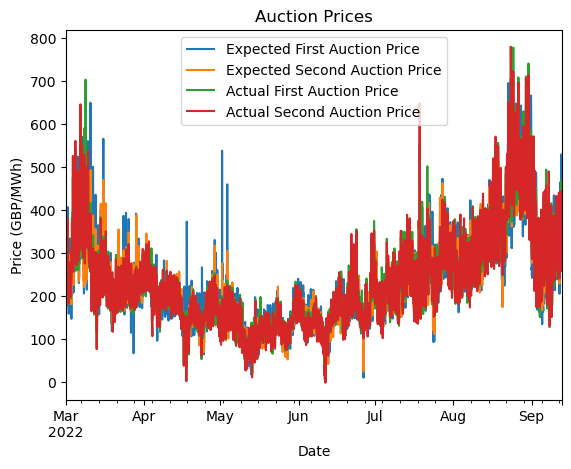

In [33]:
df['forecast_price_first_auction'].plot()
df['forecast_price_second_auction'].plot()
auction_data.loc[df.index,'price_first_auction'].plot()
auction_data.loc[df.index,'price_second_auction'].plot()

# Add chart titles, labels, and legend
plt.title('Auction Prices')
plt.xlabel('Date')
plt.ylabel('Price (GBP/MWh)')
plt.legend(['Expected First Auction Price', 'Expected Second Auction Price', 
            'Actual First Auction Price', 'Actual Second Auction Price'])

# Display the chart
plt.show()

Visualize the actual and expected auction volume over time.

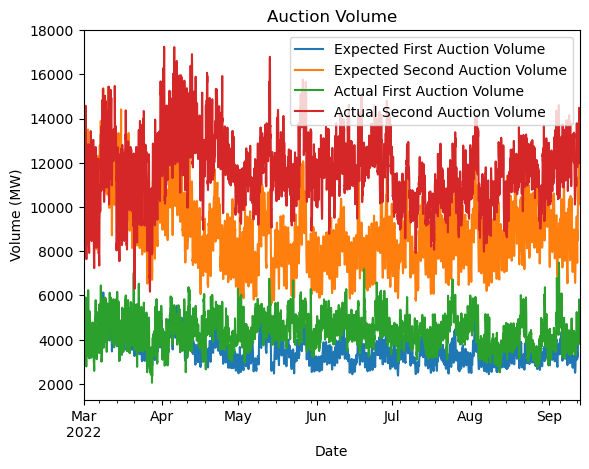

In [34]:
df['forecast_traded_volume_first_auction'].plot()
df['forecast_traded_volume_second_auction'].plot()
auction_data.loc[df.index,'traded_volume_first_auction'].plot()
auction_data.loc[df.index,'traded_volume_second_auction'].plot()

# Add chart titles, labels, and legend
plt.title('Auction Volume')
plt.xlabel('Date')
plt.ylabel('Volume (MW)')
plt.legend(['Expected First Auction Volume', 'Expected Second Auction Volume',
            'Actual First Auction Volume', 'Actual Second Auction Volume'])

# Display the chart
plt.show()

Visualize the accumulated expected profit before taxes over time.

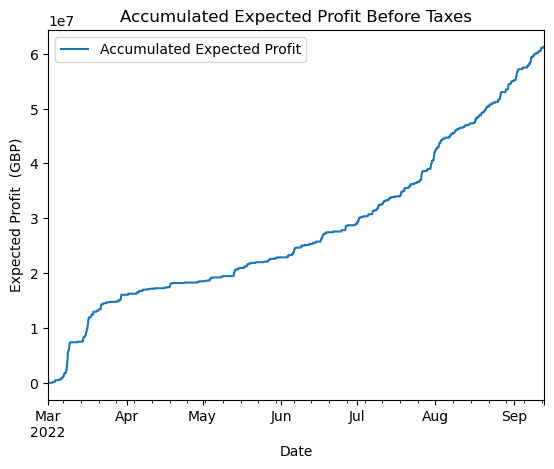

In [35]:
Expected_profit_before_taxes.cumsum().plot()

# Add chart titles, labels, and legend
plt.title('Accumulated Expected Profit Before Taxes')
plt.xlabel('Date')
plt.ylabel('Expected Profit  (GBP)')
plt.legend(['Accumulated Expected Profit'])

# Display the chart
plt.show()

Visualize the accumulated expected profit after taxes over time.

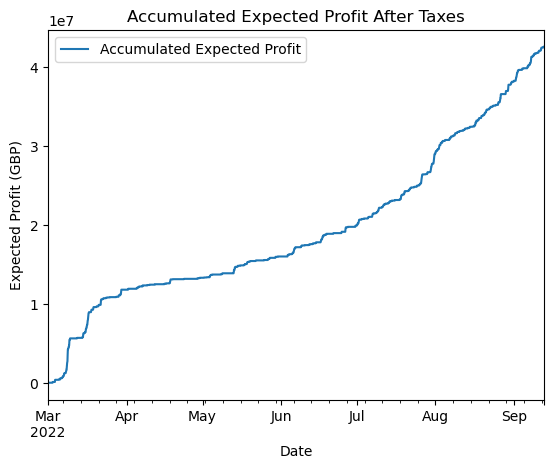

In [36]:
Expected_profit_after_taxes.cumsum().plot()

# Add chart titles, labels, and legend
plt.title('Accumulated Expected Profit After Taxes')
plt.xlabel('Date')
plt.ylabel('Expected Profit (GBP)')
plt.legend(['Accumulated Expected Profit'])

# Display the chart
plt.show()

Visualize the accumulated actual profit before taxes over time.

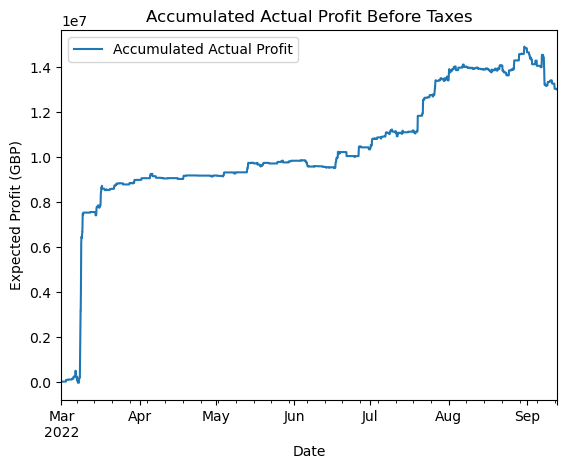

In [37]:
Actual_profit_before_taxes.cumsum().plot()

# Add chart titles, labels, and legend
plt.title('Accumulated Actual Profit Before Taxes')
plt.xlabel('Date')
plt.ylabel('Expected Profit (GBP)')
plt.legend(['Accumulated Actual Profit'])

# Display the chart
plt.show()

Visualize the accumulated actual profit after taxes over time.

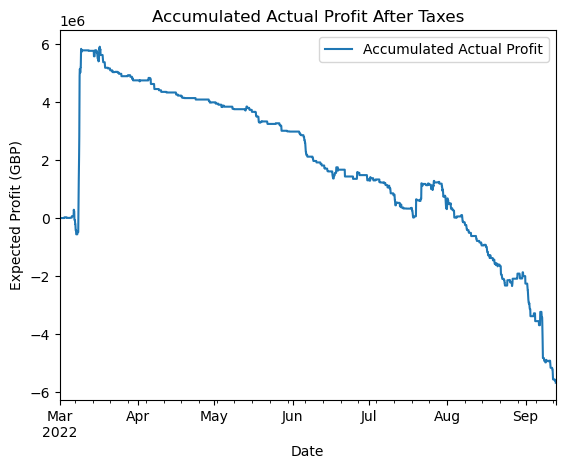

In [38]:
Actual_profit_after_taxes.cumsum().plot()

# Add chart titles, labels, and legend
plt.title('Accumulated Actual Profit After Taxes')
plt.xlabel('Date')
plt.ylabel('Expected Profit (GBP)')
plt.legend(['Accumulated Actual Profit'])

# Display the chart
plt.show()